<a href="https://colab.research.google.com/github/yinghaow525/MSBA-Projects/blob/main/Capstone%20Project/Capstone_A6_Coding_Deliverable_02_EDA_%26_Statistical_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capsone Project with Spinnaker Analytics
Team A6: Yihan Jia, Yinghao Wang, Simeng Li, Xiangshan Mu, Kaiyu Wang
> **Business Objectives**:
- The objective of the exercise is to find a tradable signal in the dataset. 

> **Project Flow**:
- Standard time series models can be used or non-parametric models like neural networks can be deployed. Suggested course of actions is as follows:
  1. Understand the dataset and what it represents
  2. Define the problem: what does 'a tradable signal' mean based on the data available (i.e. develop your modeling equation, if any)
  3. Start with simple analysis to identify patterns and outliers
  4. Develop models with increasing complexity - i.e. don't start with neural nets etc
  5. Define your success criteria - i.e. when do you know you have a tradable signal - positive (buy)/negative (sell), both are signals


In [1]:
# imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt

from google.colab import drive

from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.api import ExponentialSmoothing

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

from statsmodels.tsa.arima_model import ARIMA



from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree, neural_network
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import  AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import precision_recall_fscore_support

#reset recursionlimit
import sys
sys.setrecursionlimit(10000)

import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable

# supress filter warnings
import warnings
warnings.filterwarnings("ignore")

#plt style
plt.style.use("seaborn")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# read datasets
# try:
#   # mount my google drive
#   drive.mount('/content/drive')
#   # change directory to the path that contains dataset uploaded
#   %cd /content/drive/My Drive/Capstone Project

#   # read through google drive
#   IMF = pd.read_csv('US Sector Inst ETF.csv')
#   ETF = pd.read_csv('US Sector Inst ETF.csv')
#   RMF  = pd.read_csv('US Sector Retail MF.csv')

# except: 
  # or read through github
ETF = pd.read_csv('https://raw.githubusercontent.com/yinghaow525/MSBA-Projects/main/Capstone%20Project/Datasets/US%20Sector%20Inst%20ETF.csv')
IMF = pd.read_csv('https://raw.githubusercontent.com/yinghaow525/MSBA-Projects/main/Capstone%20Project/Datasets/US%20Sector%20Institutional%20MF.csv')
RMF = pd.read_csv('https://raw.githubusercontent.com/yinghaow525/MSBA-Projects/main/Capstone%20Project/Datasets/US%20Sector%20Retail%20MF.csv')

In [3]:
# Create type colunm
ETF['Type'] = 'ETF'
IMF['Type'] = 'IMF'
RMF['Type'] = 'RMF'

# Concat 3 dadaset
data = pd.concat([ETF, IMF, RMF], axis=0)

In [4]:
# convert report date to pandas datetime object
data['ReportDate'] = pd.to_datetime(data['ReportDate'])

In [5]:
# since all the Asset and Sector values are the same (Equity, and within US)
# we only keep Industry sector as features
data['AssetClass'] = data['AssetClass'].str.split('-')
data['Industry'] = data.AssetClass.apply(lambda x: x[0])

# drop orignal AssetClass feature
data.drop(columns='AssetClass', inplace=True)

In [6]:
# extract year & month 
data['year'], data['month'] = data['ReportDate'].dt.year, data['ReportDate'].dt.month

# Exploratory Data Analysis & Statistical Analysis

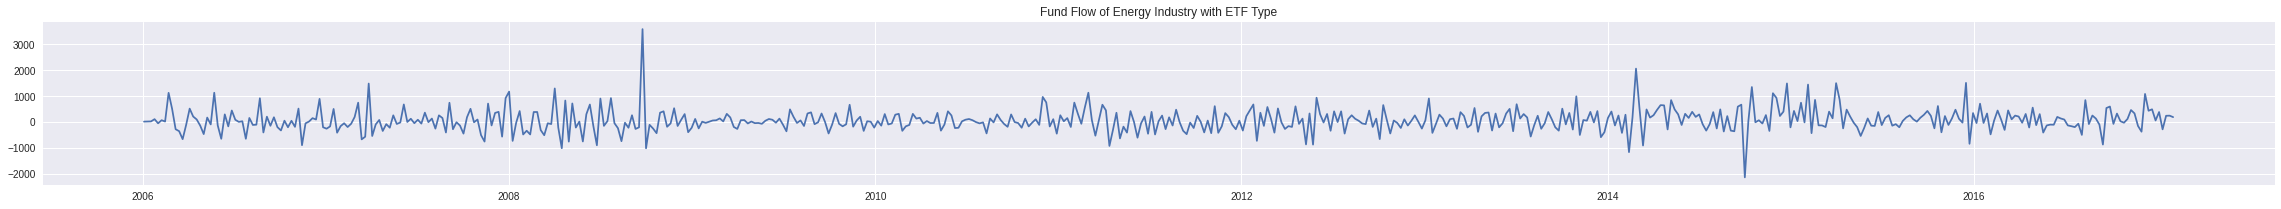

In [7]:
test = data.loc[(data.Type=='ETF') & (data.Industry == 'Energy')][['Flow','ReportDate']] 
plt.figure(figsize=(40,3))
plt.plot(test.ReportDate, test.Flow)
plt.title('Fund Flow of Energy Industry with ETF Type')
plt.show()

##Basic Distribution Check

In [8]:
# max & min value for Flow
print('Max value of Flow is {};'.format(data.Flow.max()), '\n'
      'Min value of Flow is {};'.format(data.Flow.min()),'\n'
      'Avg value of Flow is {}.'.format(data.Flow.mean()))

Max value of Flow is 23263.40489835; 
Min value of Flow is -13967.24062477; 
Avg value of Flow is 20.653445520794538.


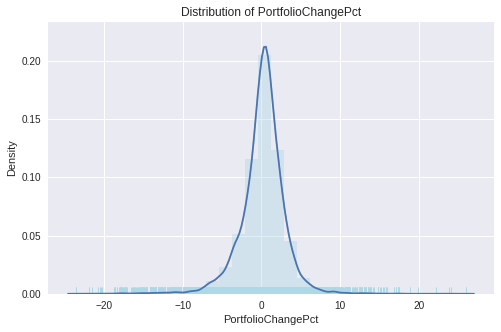

In [9]:
# distribution of entire PortfolioChangePct
plt.figure(figsize=(8,5))
sns.distplot(data.PortfolioChangePct, color='lightblue', bins=30, rug=True)
sns.distplot(data.PortfolioChangePct, hist=False)
plt.title("Distribution of PortfolioChangePct")
plt.show()

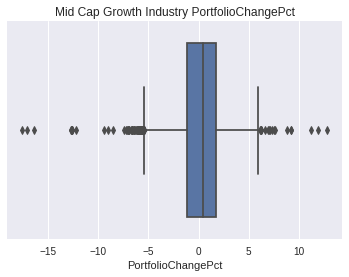

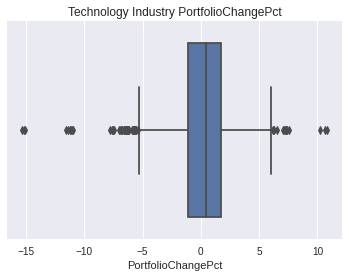

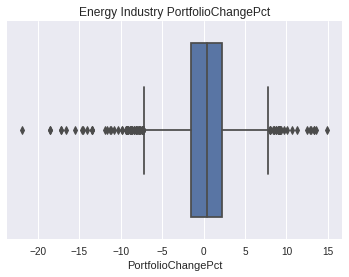

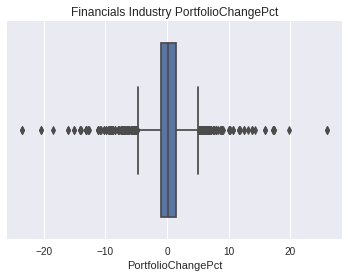

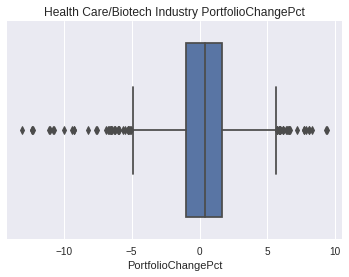

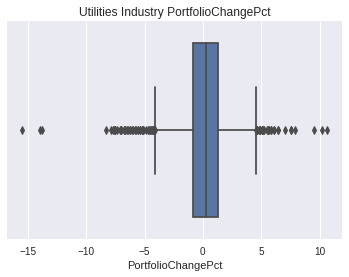

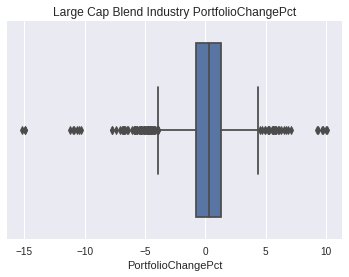

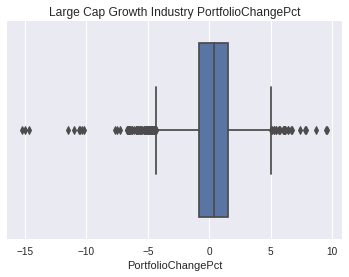

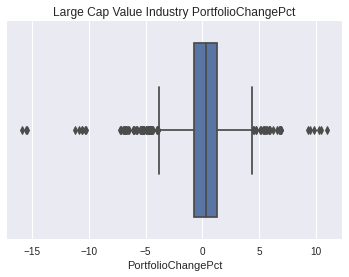

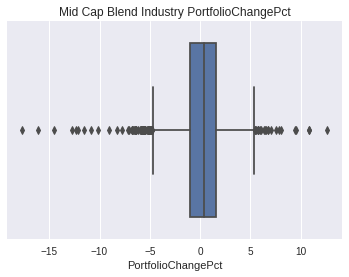

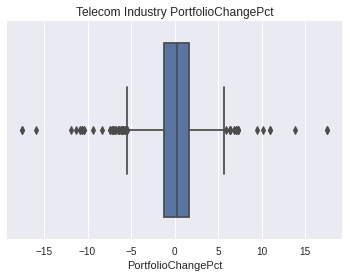

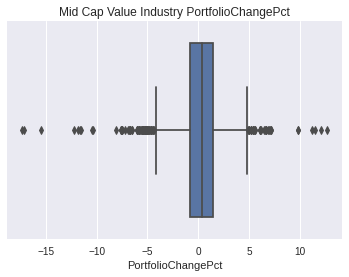

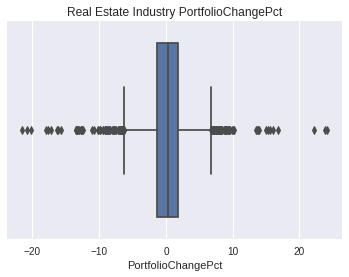

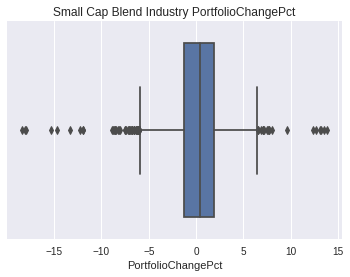

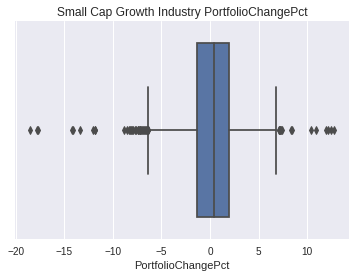

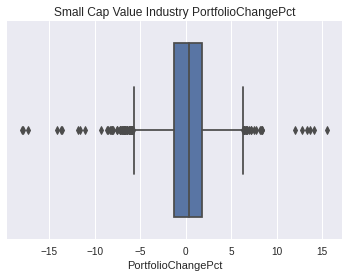

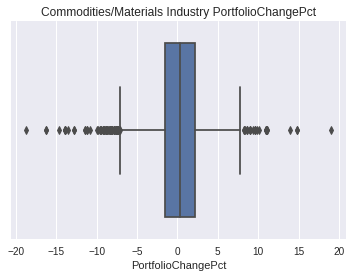

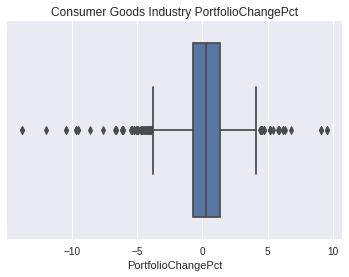

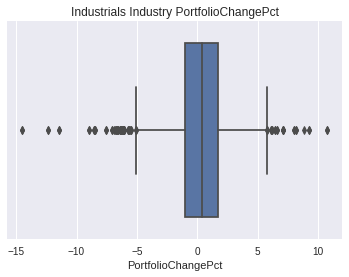

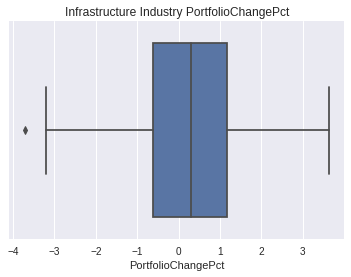

In [10]:
# plotting PortfolioChangePct distribution by industry on boxplot, we can do via a loop
for _ in data.Industry.value_counts().index:
  plt.figure(figsize=(6,4))
  sns.boxplot(data.loc[data.Industry == _].PortfolioChangePct)
  plt.title(_+' Industry PortfolioChangePct')
  plt.show()

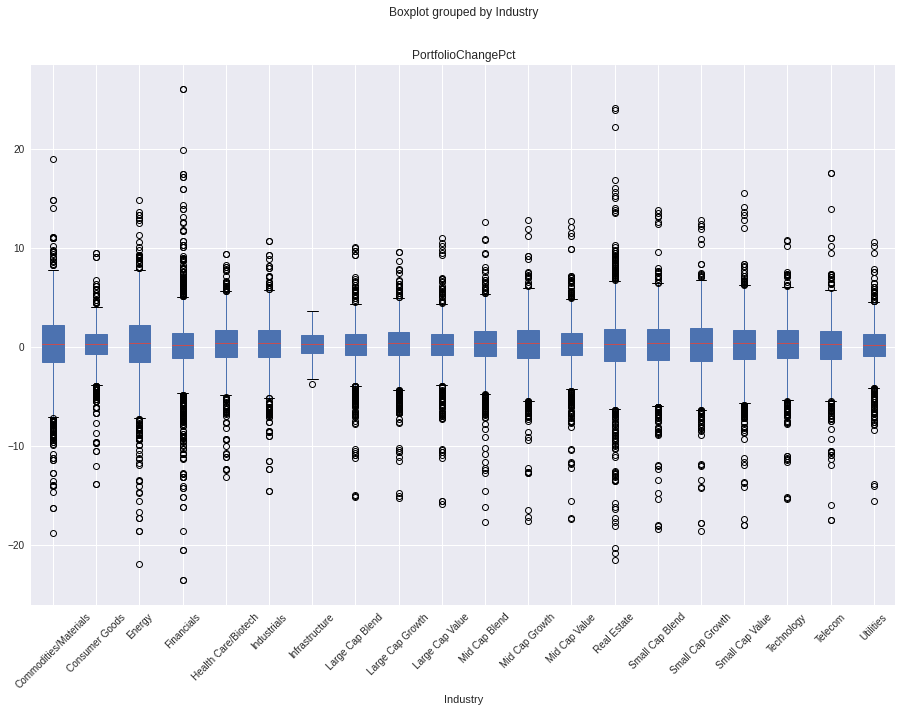

In [11]:
  # ... or agg into a single plot
  data.boxplot(column = 'PortfolioChangePct', by = 'Industry', figsize=(15,10), 
               rot = 45, fontsize = 10, patch_artist = True)
  plt.show()


  ###  outliers: >= |15| ??? 

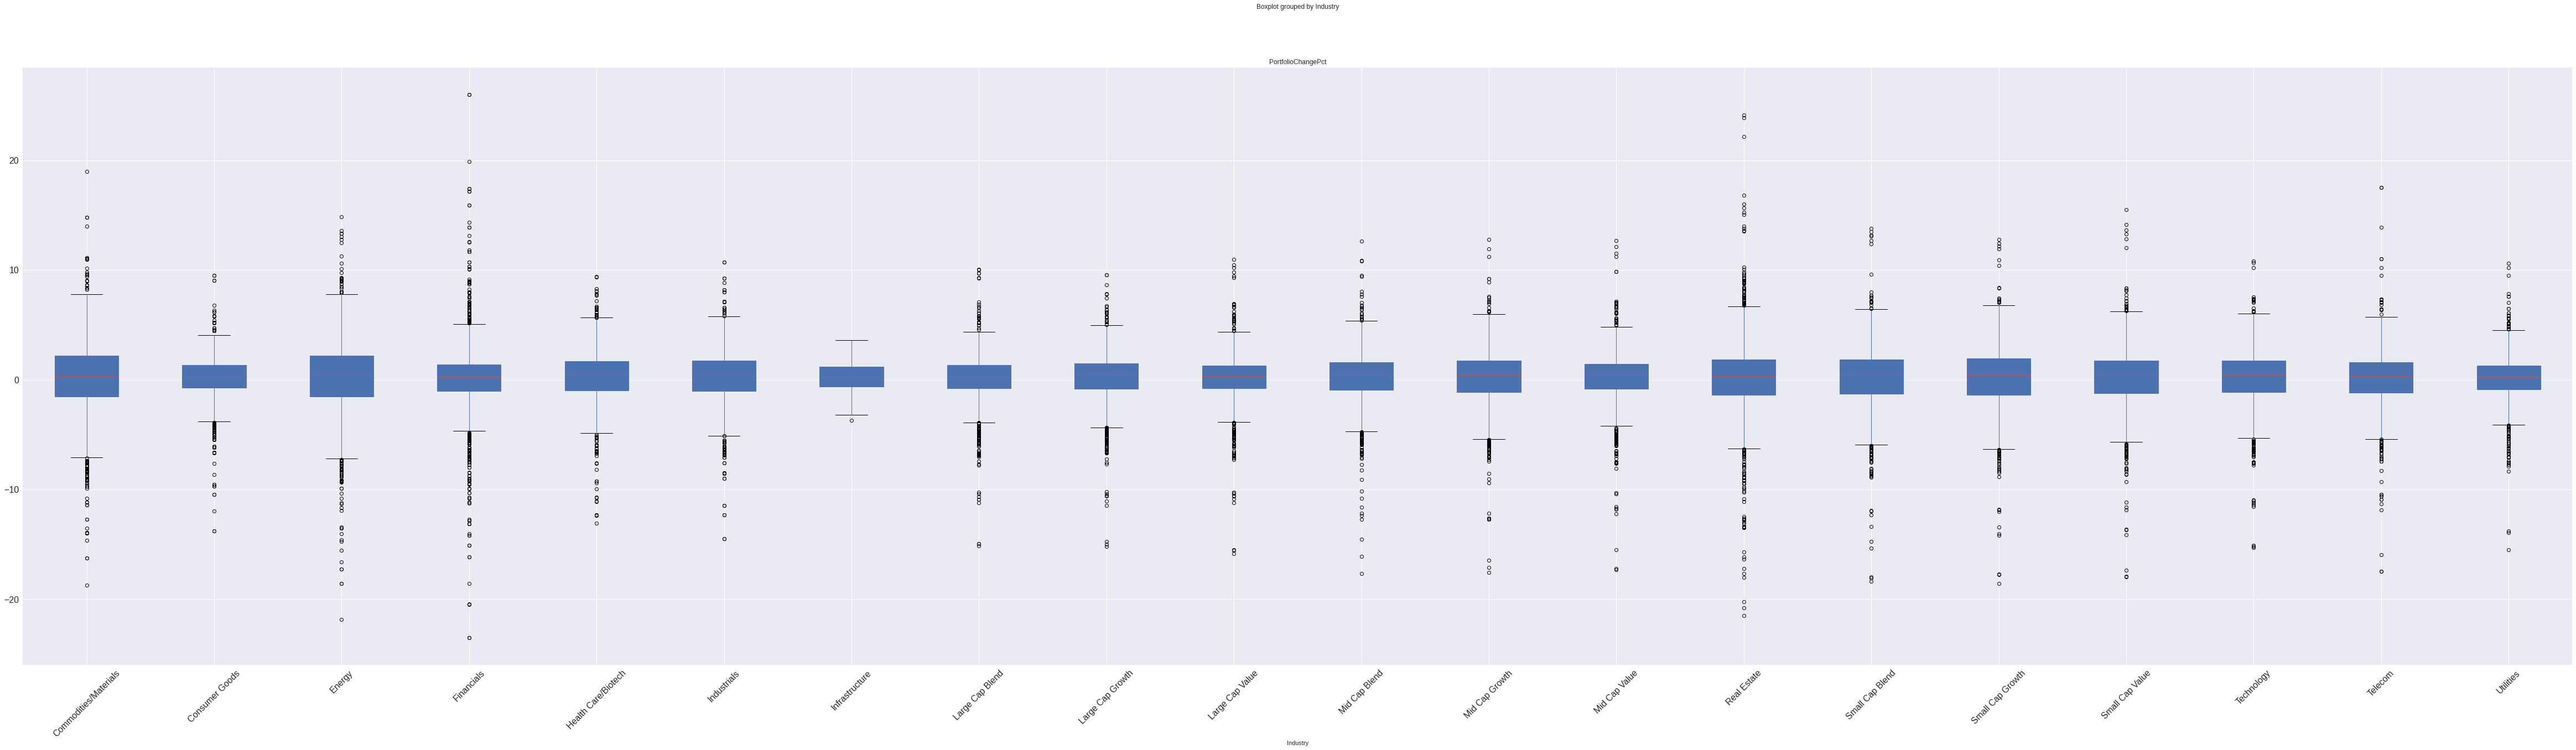

In [12]:
  # ... or agg into a single plot
  # wide version

  data.boxplot(column = 'PortfolioChangePct', by = 'Industry', figsize=(80,20), 
               rot = 45, fontsize = 16, patch_artist = True)
  plt.show()

  ###  outliers: >= |15| ??? 

In [13]:
# group by education
groupby_type = data.groupby('Type').mean()
groupby_type.reset_index(inplace=True)
groupby_type

,Type,Flow,FlowPct,AssetsEnd,PortfolioChangePct,year,month
0,ETF,62.592954,0.266612,30641.955796,0.172921,2011.052349,6.485958
1,IMF,46.247082,0.289701,59240.805803,0.166809,2011.059090,6.487610
2,RMF,-49.033985,0.381269,46085.848006,0.148504,2011.182133,6.503562


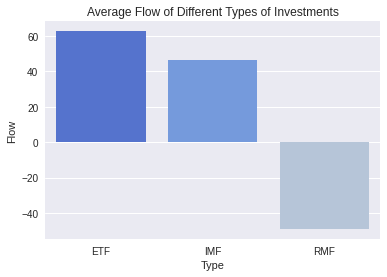

In [14]:
sns.barplot(groupby_type.Type, groupby_type.Flow, data=groupby_type, palette=["royalblue","cornflowerblue","lightsteelblue"])
plt.title('Average Flow of Different Types of Investments')
plt.show()

In [15]:
groupby_month = data.groupby('month').mean()
groupby_month.reset_index(inplace=True)
groupby_month

,month,Flow,FlowPct,AssetsEnd,PortfolioChangePct,year
0,1,-32.475495,0.139309,45333.427745,-0.109616,2011.479578
1,2,-33.873608,0.395732,43039.036434,0.177028,2011.197145
2,3,44.125802,0.640563,43228.952366,0.583817,2011.021860
3,4,-19.574994,0.463890,44889.925190,0.644990,2011.086506
4,5,-27.586862,0.049561,44162.754668,-0.190326,2010.924926
5,6,33.833469,0.098862,45035.580521,-0.223289,2011.133585
6,7,46.369918,0.374636,46066.357727,0.483851,2011.127760
7,8,-7.249800,0.197461,45288.663950,-0.154638,2010.990221
8,9,57.010341,0.393784,45663.886324,0.144342,2011.060309
9,10,6.533923,0.000688,45860.972009,-0.109039,2011.015124


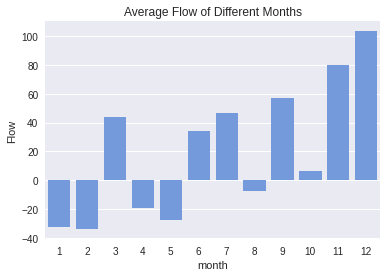

In [16]:
sns.barplot(groupby_month.month,groupby_month.Flow, data=groupby_month, color="cornflowerblue")
plt.title('Average Flow of Different Months')
plt.show()

In [17]:
groupby_month = data.groupby('year').mean()
groupby_month.reset_index(inplace=True)
groupby_month

,year,Flow,FlowPct,AssetsEnd,PortfolioChangePct,month
0,2006,9.709595,0.167481,20774.625815,0.294400,6.563777
1,2007,24.347559,0.388225,28292.320694,0.191274,6.461538
2,2008,33.632580,0.338836,27675.884230,-0.842377,6.528302
3,2009,-16.307381,0.410635,23518.159685,0.604485,6.615385
4,2010,6.833270,0.249576,30376.103635,0.361180,6.576923
5,2011,10.570226,0.201189,37835.369459,0.002048,6.555936
6,2012,7.170200,0.116301,43563.443944,0.281452,6.480769
7,2013,64.293285,0.273688,54932.094255,0.497152,6.442308
8,2014,60.672181,0.073182,68550.205126,0.213110,6.532893
9,2015,-22.177792,0.373536,77872.282476,-0.055566,6.615385


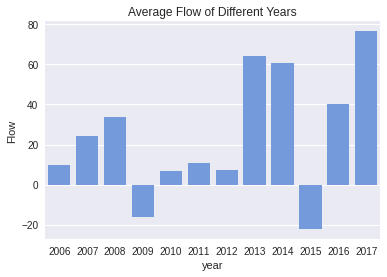

In [18]:
sns.barplot(groupby_month.year,groupby_month.Flow, data=groupby_month, color="cornflowerblue")
plt.title('Average Flow of Different Years')
plt.show()

In [19]:
groupby_indus = data.groupby('Industry').mean()
groupby_indus = groupby_indus[['Flow','FlowPct','PortfolioChangePct','AssetsEnd']]
groupby_indus.T

Industry,Commodities/Materials,Consumer Goods,Energy,Financials,Health Care/Biotech,Industrials,Infrastructure,Large Cap Blend,Large Cap Growth,Large Cap Value,Mid Cap Blend,Mid Cap Growth,Mid Cap Value,Real Estate,Small Cap Blend,Small Cap Growth,Small Cap Value,Technology,Telecom,Utilities
Flow,4.618448,14.705494,56.642795,43.174948,18.434165,14.458547,-0.185774,234.353609,-56.994477,18.802714,37.528139,-33.864993,0.415125,29.382265,19.458505,-24.579755,1.050384,12.797373,0.941891,0.276796
FlowPct,0.527914,0.706988,0.327309,0.468821,0.104273,0.370827,14.146915,0.095324,-0.007993,0.083720,0.076739,0.000748,0.007356,0.187202,0.188832,-0.034364,0.036308,0.102159,2.160087,0.059619
PortfolioChangePct,0.146966,0.169154,0.117991,0.076565,0.212619,0.198256,0.246716,0.150790,0.177993,0.144915,0.175615,0.171738,0.171795,0.169534,0.185696,0.187447,0.183333,0.200060,0.121771,0.135717
AssetsEnd,2845.521245,9659.567516,19386.442725,16082.303532,13996.433462,4459.504929,12.503560,286876.680400,120252.248497,131580.595345,42831.562165,38112.991915,30357.028293,23929.996101,45352.048328,27098.685214,19300.928749,14354.973156,670.525253,6773.621061


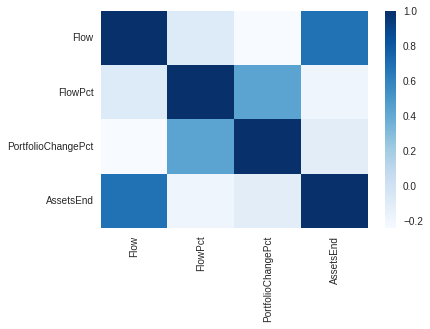

In [20]:
fig=sns.heatmap(groupby_indus.corr(), cmap="Blues")
fig

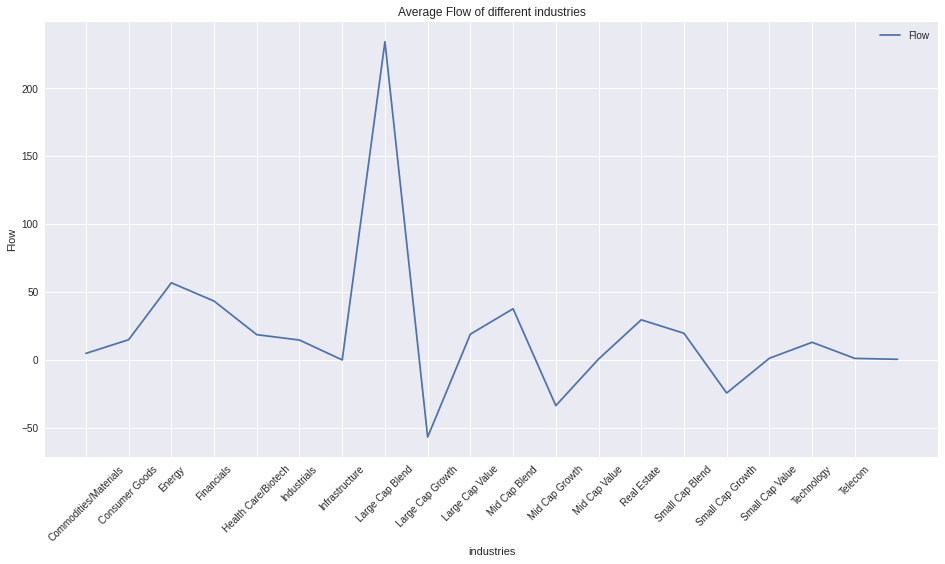

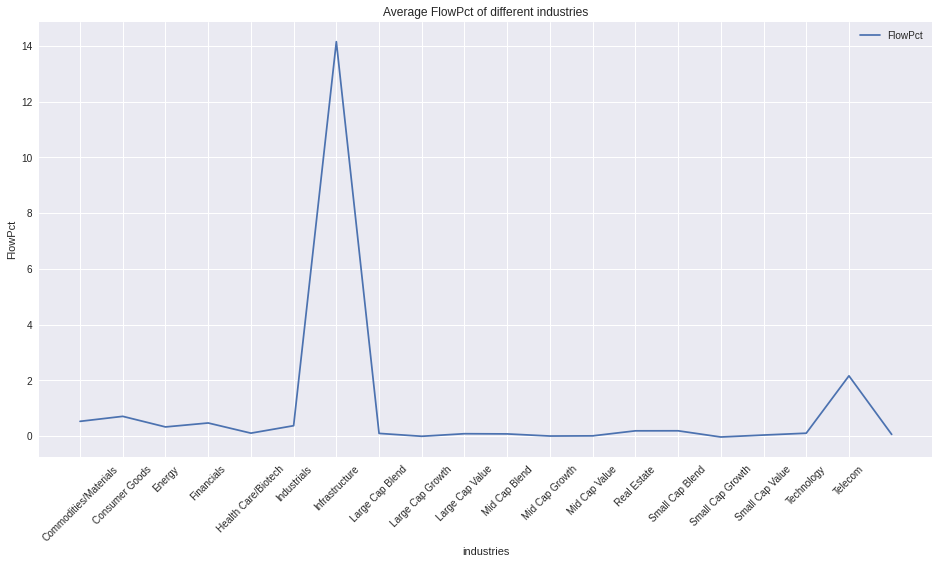

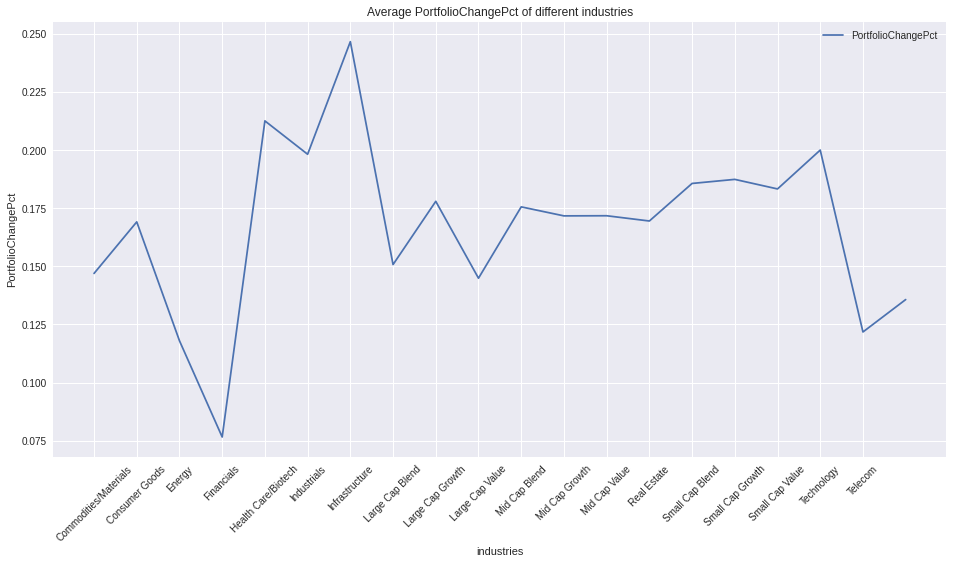

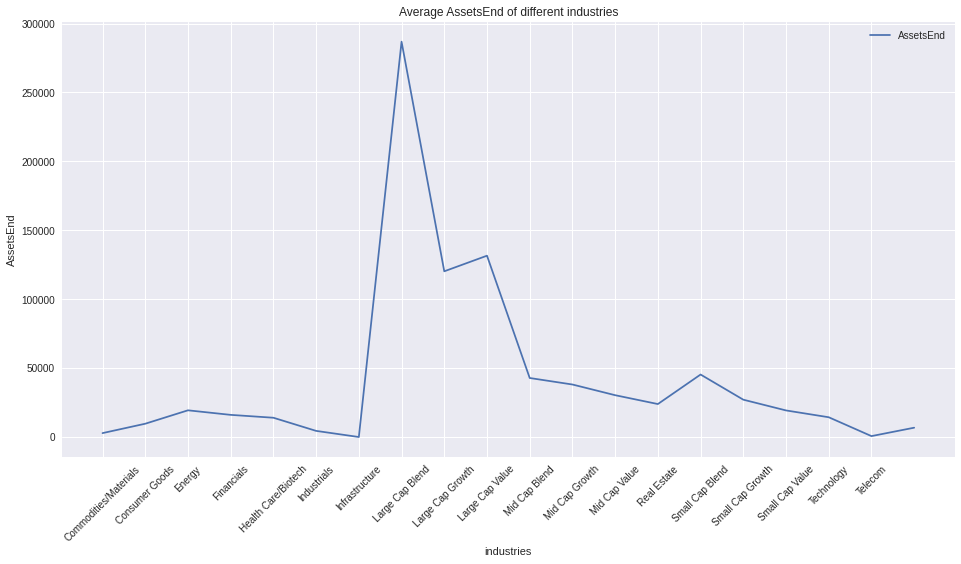

In [21]:
list_ind=['Flow','FlowPct','PortfolioChangePct','AssetsEnd']
for i in list_ind:
  groupby_indus = data.groupby('Industry').mean()
  groupby_indus = groupby_indus[[i]]
  groupby_indus.plot(figsize=(16,8))
  scale_ls = range(19)
  index_ls = ['Commodities/Materials','Consumer Goods','Energy','Financials','Health Care/Biotech','Industrials','Infrastructure','Large Cap Blend','Large Cap Growth','Large Cap Value','Mid Cap Blend','Mid Cap Growth','Mid Cap Value','Real Estate','Small Cap Blend','Small Cap Growth','Small Cap Value','Technology','Telecom','Utilities']
  plt.xticks(scale_ls,index_ls,rotation=45)
  plt.title('Average ' + i + ' of different industries')
  plt.xlabel('industries')
  plt.ylabel(i)
  plt.legend()
  plt.show()

## Discountinuity Check

We find four industies have less data records than others, these four industries are: `Commodities/Materials`, `Consumer Goods`, `Industrials`, and `Infrastructure`.

We want to understand the missing records in 2 ways:
1. whether certain type have less records than the others;
2. if so, we want to know where the record missing is: at the front of the timeline, at the back, in the middle or with not pattern.

### For `Commodities/Materials`:

In [22]:
# checking missing data for Commodities/Materials, and RMF type has less records
data.loc[data.Industry == 'Commodities/Materials'].Type.value_counts()

ETF    579
IMF    579
RMF    542
Name: Type, dtype: int64

In [23]:
# and we figure out that Commodities/Materials has missing RMF records at the beginning of entire timeline 
print('The most recent ReportDate for RMF type Commodities/Materials industry is {};'.format(data.loc[(data.Industry == 'Commodities/Materials') & 
                                                 (data.Type == 'RMF')].ReportDate.max()), '\n'
      'The least recent ReportDate for RMF type Commodities/Materials industry is {}.'.format(data.loc[(data.Industry == 'Commodities/Materials') & 
                                                 (data.Type == 'RMF')].ReportDate.min()),'\n'
      'Compare with other typed while same industry funds, their most recent ReportDate is {};'.format(data.loc[(data.Industry == 'Commodities/Materials') & 
                                                 (data.Type == 'IMF')].ReportDate.max()), '\n'
      'and their least recent ReportDate is {}.'.format(data.loc[(data.Industry == 'Commodities/Materials') & 
                                                 (data.Type == 'IMF')].ReportDate.min())
                                                 )

The most recent ReportDate for RMF type Commodities/Materials industry is 2017-02-01 00:00:00; 
The least recent ReportDate for RMF type Commodities/Materials industry is 2006-09-20 00:00:00. 
Compare with other typed while same industry funds, their most recent ReportDate is 2017-02-01 00:00:00; 
and their least recent ReportDate is 2006-01-04 00:00:00.


In [24]:
from datetime import datetime
def week_num(start_time, end_time):
  # week_start = datetime.strptime(start_time, '%Y-%m-%d')
  # week_end = datetime.strptime(end_time, '%Y-%m-%d')
  year_week_num = 52
  week_end_year = end_time.year
  week_start_year = start_time.year
  week_end_num = int(datetime.strftime(end_time, '%W'))
  week_start_num = int(datetime.strftime(start_time, '%W'))

  diff = (week_end_year - week_start_year) * year_week_num + week_end_num - week_start_num
  return diff

In [25]:
# calculate that different in weeks for two type's start time is equals to number of missing records
# no other missing data otherwise, no discontinuity exists
week_num(data.loc[(data.Industry == 'Commodities/Materials') & (data.Type == 'IMF')].ReportDate.min(), # start time
         data.loc[(data.Industry == 'Commodities/Materials') & (data.Type == 'RMF')].ReportDate.min(), # end time
)

37

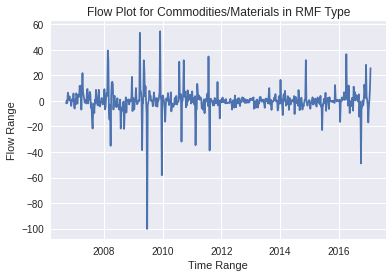

In [26]:
# Commodities/Materials Flow plot for 3 types:

# RMF type has a later start than the other two, and the range is smaller
plt.plot(data.loc[(data.Industry == 'Commodities/Materials') & 
                                                 (data.Type == 'RMF')].ReportDate, 
         data.loc[(data.Industry == 'Commodities/Materials') & 
                                                 (data.Type == 'RMF')].Flow,
         label = 'RMF')
plt.title('Flow Plot for Commodities/Materials in RMF Type')
plt.xlabel('Time Range')
plt.ylabel('Flow Range')
plt.show()

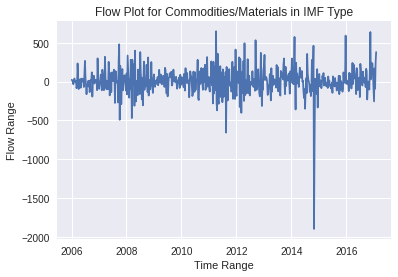

In [27]:
# IMF type generally stay within range -500 ~ 500, while has a large outflow reached about -2000 in 2014 May
plt.plot(data.loc[(data.Industry == 'Commodities/Materials') & 
                                                 (data.Type == 'IMF')].ReportDate, 
         data.loc[(data.Industry == 'Commodities/Materials') & 
                                                 (data.Type == 'IMF')].Flow,
         label = 'IMF')
plt.title('Flow Plot for Commodities/Materials in IMF Type')
plt.xlabel('Time Range')
plt.ylabel('Flow Range')
plt.show()

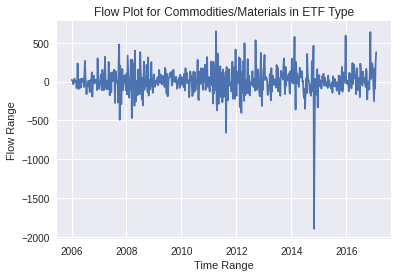

In [28]:
# RMF type is very similar to that of IMF
# the similarity exists in trend, and value amount of flow
plt.plot(data.loc[(data.Industry == 'Commodities/Materials') & 
                                                 (data.Type == 'ETF')].ReportDate, 
         data.loc[(data.Industry == 'Commodities/Materials') & 
                                                 (data.Type == 'ETF')].Flow,
         label = 'ETF')
plt.title('Flow Plot for Commodities/Materials in ETF Type')
plt.xlabel('Time Range')
plt.ylabel('Flow Range')
plt.show()

In [29]:
# flow amount for IMF
data.loc[(data.Industry == 'Commodities/Materials') & 
                                                 (data.Type == 'IMF')].Flow

0        380.126769
20       250.977996
40       -92.352798
60       169.136975
80      -255.592884
            ...    
10922      0.000000
10941    -34.945224
10960     -2.269946
10979     11.561203
10998     23.148567
Name: Flow, Length: 579, dtype: float64

In [30]:
# flow amount for ETF
data.loc[(data.Industry == 'Commodities/Materials') & 
                                                 (data.Type == 'ETF')].Flow

0        378.578706
19       250.733560
38       -92.853355
57       168.711676
76      -254.535873
            ...    
10908      0.000000
10927    -34.945224
10946     -2.269946
10965     11.561203
10984     23.148567
Name: Flow, Length: 579, dtype: float64

### For `Consumer Goods`:

In [31]:
# checking missing data for Comsumer Goods
# similarly, this industry also has less records in RMF type
data.loc[data.Industry == 'Consumer Goods'].Type.value_counts()

ETF    579
IMF    579
RMF    542
Name: Type, dtype: int64

In [32]:
# and we figure out that Consumer Goods has missing RMF records at the beginning of entire timeline 
print('The most recent ReportDate for RMF type Consumer Goods industry is {};'.format(data.loc[(data.Industry == 'Consumer Goods') & 
                                                 (data.Type == 'RMF')].ReportDate.max()), '\n'
      'The least recent ReportDate for RMF type Consumer Goods industry is {}.'.format(data.loc[(data.Industry == 'Consumer Goods') & 
                                                 (data.Type == 'RMF')].ReportDate.min()),'\n'
      'Compare with other typed while same industry funds, their most recent ReportDate is {};'.format(data.loc[(data.Industry == 'Consumer Goods') & 
                                                 (data.Type == 'IMF')].ReportDate.max()), '\n'
      'and their least recent ReportDate is {}.'.format(data.loc[(data.Industry == 'Consumer Goods') & 
                                                 (data.Type == 'IMF')].ReportDate.min())
                                                 )

The most recent ReportDate for RMF type Consumer Goods industry is 2017-02-01 00:00:00; 
The least recent ReportDate for RMF type Consumer Goods industry is 2006-09-20 00:00:00. 
Compare with other typed while same industry funds, their most recent ReportDate is 2017-02-01 00:00:00; 
and their least recent ReportDate is 2006-01-04 00:00:00.


In [33]:
# calculate that different in weeks for two type's start time is equals to number of missing records
# no other missing data otherwise, no discontinuity exists
week_num(data.loc[(data.Industry == 'Consumer Goods') & (data.Type == 'IMF')].ReportDate.min(), # start time
         data.loc[(data.Industry == 'Consumer Goods') & (data.Type == 'RMF')].ReportDate.min(), # end time
)

37

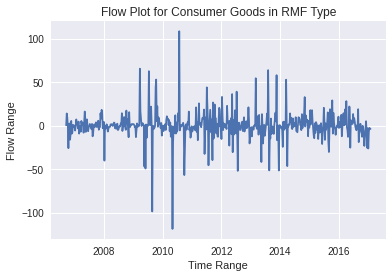

In [34]:
# Consumer Goods Flow plot for 3 types:

# RMF type has a later start than the other two, and the Flow range is smaller
plt.plot(data.loc[(data.Industry == 'Consumer Goods') & 
                                                 (data.Type == 'RMF')].ReportDate, 
         data.loc[(data.Industry == 'Consumer Goods') & 
                                                 (data.Type == 'RMF')].Flow,
         label = 'RMF')
plt.title('Flow Plot for Consumer Goods in RMF Type')
plt.xlabel('Time Range')
plt.ylabel('Flow Range')
plt.show()

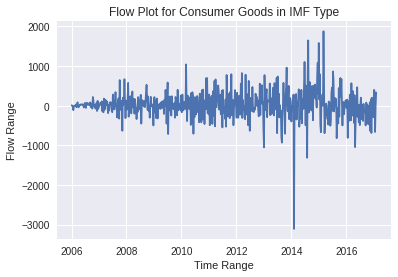

In [35]:
# most flow amount is within -800 ~ 1000 range, while there exists extreme drop in the beginning of 2014
plt.plot(data.loc[(data.Industry == 'Consumer Goods') & 
                                                 (data.Type == 'IMF')].ReportDate, 
         data.loc[(data.Industry == 'Consumer Goods') & 
                                                 (data.Type == 'IMF')].Flow,
         label = 'IMF')
plt.title('Flow Plot for Consumer Goods in IMF Type')
plt.xlabel('Time Range')
plt.ylabel('Flow Range')
plt.show()

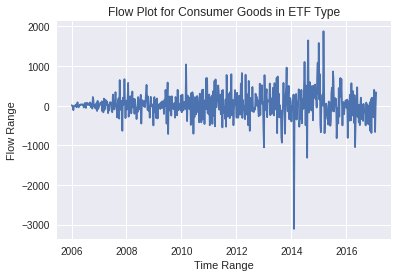

In [36]:
# this time, the RMF type is still very similar to IMF one
plt.plot(data.loc[(data.Industry == 'Consumer Goods') & 
                                                 (data.Type == 'ETF')].ReportDate, 
         data.loc[(data.Industry == 'Consumer Goods') & 
                                                 (data.Type == 'ETF')].Flow,
         label = 'ETF')
plt.title('Flow Plot for Consumer Goods in ETF Type')
plt.xlabel('Time Range')
plt.ylabel('Flow Range')
plt.show()

### For `Industrials`:

In [37]:
# checking missing data for Industrials
# similarly, this industry also has less records in RMF type
data.loc[data.Industry == 'Industrials'].Type.value_counts()

ETF    579
IMF    579
RMF    277
Name: Type, dtype: int64

In [38]:
# and we figure out that Industrials has missing RMF records at the beginning of entire timeline 
print('The most recent ReportDate for RMF type Industrials industry is {};'.format(data.loc[(data.Industry == 'Industrials') & 
                                                 (data.Type == 'RMF')].ReportDate.max()), '\n'
      'The least recent ReportDate for RMF type Industrials industry is {}.'.format(data.loc[(data.Industry == 'Industrials') & 
                                                 (data.Type == 'RMF')].ReportDate.min()),'\n'
      'Compare with other typed while same industry funds, their most recent ReportDate is {};'.format(data.loc[(data.Industry == 'Industrials') & 
                                                 (data.Type == 'IMF')].ReportDate.max()), '\n'
      'and their least recent ReportDate is {}.'.format(data.loc[(data.Industry == 'Industrials') & 
                                                 (data.Type == 'IMF')].ReportDate.min())
                                                 )

The most recent ReportDate for RMF type Industrials industry is 2017-02-01 00:00:00; 
The least recent ReportDate for RMF type Industrials industry is 2011-10-19 00:00:00. 
Compare with other typed while same industry funds, their most recent ReportDate is 2017-02-01 00:00:00; 
and their least recent ReportDate is 2006-01-04 00:00:00.


In [39]:
# calculate that different in weeks for two type's start time is equals to number of missing records
# no other missing data otherwise, no discontinuity exists 
week_num(data.loc[(data.Industry == 'Industrials') & (data.Type == 'IMF')].ReportDate.min(), # start time
         data.loc[(data.Industry == 'Industrials') & (data.Type == 'RMF')].ReportDate.min(), # end time
)

301

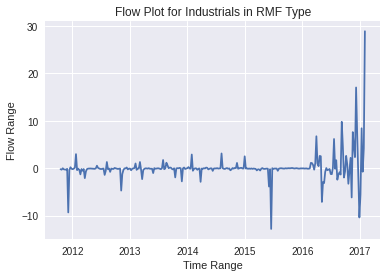

In [40]:
# Industrials plot for 3 types:

# RMF type has a much later start than the other two, and the Flow range is smaller
plt.plot(data.loc[(data.Industry == 'Industrials') & 
                                                 (data.Type == 'RMF')].ReportDate, 
         data.loc[(data.Industry == 'Industrials') & 
                                                 (data.Type == 'RMF')].Flow,
         label = 'RMF')
plt.title('Flow Plot for Industrials in RMF Type')
plt.xlabel('Time Range')
plt.ylabel('Flow Range')
plt.show()

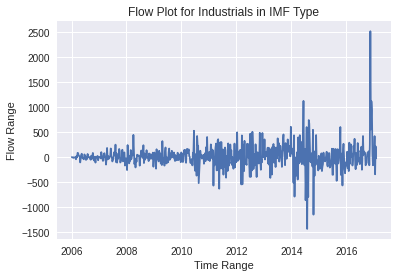

In [41]:
# most flow amount is within -500 ~ 500 range, while there exists extreme drop in 2014
# and extreme rise in 2017
plt.plot(data.loc[(data.Industry == 'Industrials') & 
                                                 (data.Type == 'IMF')].ReportDate, 
         data.loc[(data.Industry == 'Industrials') & 
                                                 (data.Type == 'IMF')].Flow,
         label = 'IMF')
plt.title('Flow Plot for Industrials in IMF Type')
plt.xlabel('Time Range')
plt.ylabel('Flow Range')
plt.show()

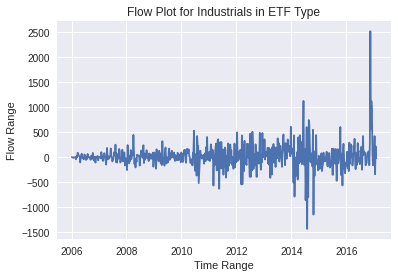

In [42]:
# this time, the RMF type is not similar to IMF one,
# the trend is very unstable, very frequent rises and drops during the timeline
plt.plot(data.loc[(data.Industry == 'Industrials') & 
                                                 (data.Type == 'ETF')].ReportDate, 
         data.loc[(data.Industry == 'Industrials') & 
                                                 (data.Type == 'ETF')].Flow,
         label = 'ETF')
plt.title('Flow Plot for Industrials in ETF Type')
plt.xlabel('Time Range')
plt.ylabel('Flow Range')
plt.show()

### For `Infrastructure`:

In [43]:
# checking missing data for Infrastructure
# this industry has too few records for visualization
data.loc[data.Industry == 'Infrastructure'].Type.value_counts()

RMF    43
IMF    16
ETF     2
Name: Type, dtype: int64

In [44]:
# and we figure out that Industrials has missing RMF records at the beginning of entire timeline 
print('The most recent ReportDate for RMF type Industrials industry is {};'.format(data.loc[(data.Industry == 'Infrastructure') & 
                                                 (data.Type == 'RMF')].ReportDate.max()), '\n'
      'The least recent ReportDate for RMF type Industrials industry is {}.'.format(data.loc[(data.Industry == 'Infrastructure') & 
                                                 (data.Type == 'RMF')].ReportDate.min()),'\n'
      'Compare with IMF type while same industry funds, their most recent ReportDate is {};'.format(data.loc[(data.Industry == 'Infrastructure') & 
                                                 (data.Type == 'IMF')].ReportDate.max()), '\n'
      'and their least recent ReportDate is {}.'.format(data.loc[(data.Industry == 'Infrastructure') & 
                                                 (data.Type == 'IMF')].ReportDate.min()), '\n'
       'Compare with ETF type while same industry funds, their most recent ReportDate is {};'.format(data.loc[(data.Industry == 'Infrastructure') & 
                                                 (data.Type == 'ETF')].ReportDate.max()), '\n'
      'and their least recent ReportDate is {}.'.format(data.loc[(data.Industry == 'Infrastructure') & 
                                                 (data.Type == 'ETF')].ReportDate.min())
                                                 )

The most recent ReportDate for RMF type Industrials industry is 2017-02-01 00:00:00; 
The least recent ReportDate for RMF type Industrials industry is 2016-04-13 00:00:00. 
Compare with IMF type while same industry funds, their most recent ReportDate is 2017-02-01 00:00:00; 
and their least recent ReportDate is 2014-10-01 00:00:00. 
Compare with ETF type while same industry funds, their most recent ReportDate is 2014-10-08 00:00:00; 
and their least recent ReportDate is 2014-10-01 00:00:00.


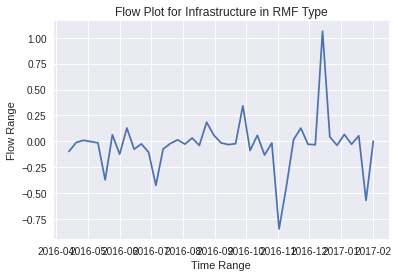

In [45]:
# Infrastructure plot for 3 types:

# RMF has less than 1 year records
plt.plot(data.loc[(data.Industry == 'Infrastructure') & 
                                                 (data.Type == 'RMF')].ReportDate, 
         data.loc[(data.Industry == 'Infrastructure') & 
                                                 (data.Type == 'RMF')].Flow,
         label = 'RMF')
plt.title('Flow Plot for Infrastructure in RMF Type')
plt.xlabel('Time Range')
plt.ylabel('Flow Range')
plt.show()

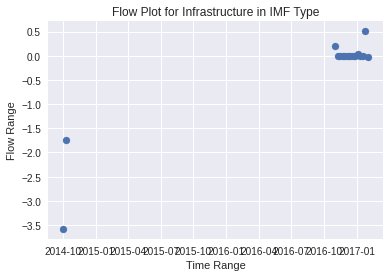

In [46]:
# IMF has only 4 week records
# and the data exists time-line discountinuity
plt.scatter(x=data.loc[(data.Industry == 'Infrastructure') & 
                                                 (data.Type == 'IMF')].ReportDate, 
         y=data.loc[(data.Industry == 'Infrastructure') & 
                                                 (data.Type == 'IMF')].Flow,
         label = 'IMF')
plt.title('Flow Plot for Infrastructure in IMF Type')
plt.xlabel('Time Range')
plt.ylabel('Flow Range')
plt.show()

## Time Series Related Plots

###Smoothing Trend

The moving average can remove the short-term fluctuations of the time series and make the data smooth, so that the trend characteristics of the series can be easily seen.

The chart below shows AssetsEnd data for 4 industry ETF/IMF/RMF stocks along with a 30-week simple moving average. Moving averages smooth out volatility, thus showing long-term volatility trends.

In [47]:
from matplotlib.pyplot import MultipleLocator

In [48]:
dataSMA = data[(data['Industry']=='Health Care/Biotech') & (data['Type']=='ETF')]
dataSMA.sort_index(axis=0,ascending=False,inplace=True)
dataSMA['SMA_3'] = dataSMA['AssetsEnd'].rolling(window=3).mean()
dataSMA['SMA_5'] = dataSMA['AssetsEnd'].rolling(window=5).mean()
dataSMA = dataSMA[['ReportDate','AssetsEnd','SMA_3','SMA_5']]
print(dataSMA)

      ReportDate     AssetsEnd         SMA_3         SMA_5
10988 2006-01-04   2601.925992           NaN           NaN
10969 2006-01-11   2713.500430           NaN           NaN
10950 2006-01-18   2820.538463   2711.988295           NaN
10931 2006-01-25   2706.582457   2746.873783           NaN
10912 2006-02-01   2829.093709   2785.404876   2734.328210
...          ...           ...           ...           ...
80    2017-01-04  36302.502477  35655.129299  35486.210045
61    2017-01-11  37003.864299  36239.294229  35852.612440
42    2017-01-18  36682.947283  36663.104686  36130.439896
23    2017-01-25  35612.145402  36432.985661  36202.595074
4     2017-02-01  36846.852743  36380.648476  36489.662441

[579 rows x 4 columns]


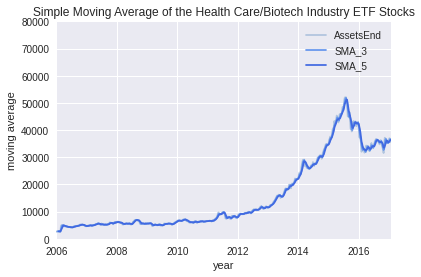

In [49]:
dataSMA.plot(kind='line', x='ReportDate', y=['AssetsEnd','SMA_3','SMA_5'], color=['lightsteelblue','cornflowerblue','royalblue'])
plt.legend()
plt.xlabel('year')
plt.ylabel('moving average')
plt.title('Simple Moving Average of the Health Care/Biotech Industry ETF Stocks')
y_major_locator=MultipleLocator(10000)
ax=plt.gca()
ax.yaxis.set_major_locator(y_major_locator)
plt.ylim(0,80000)
plt.show()

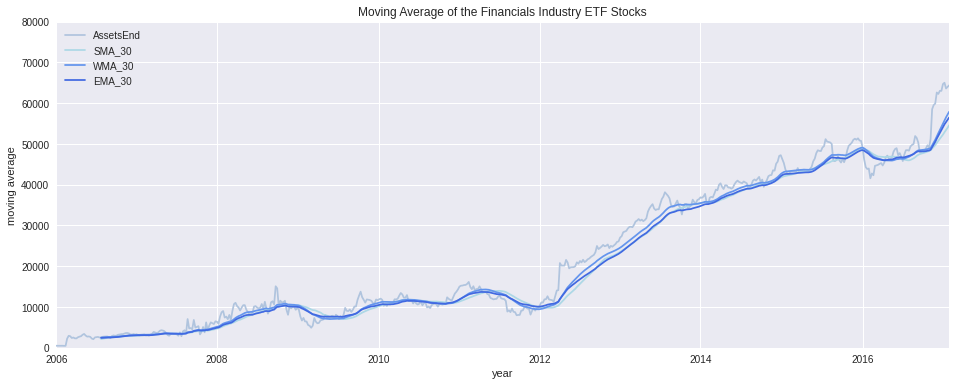

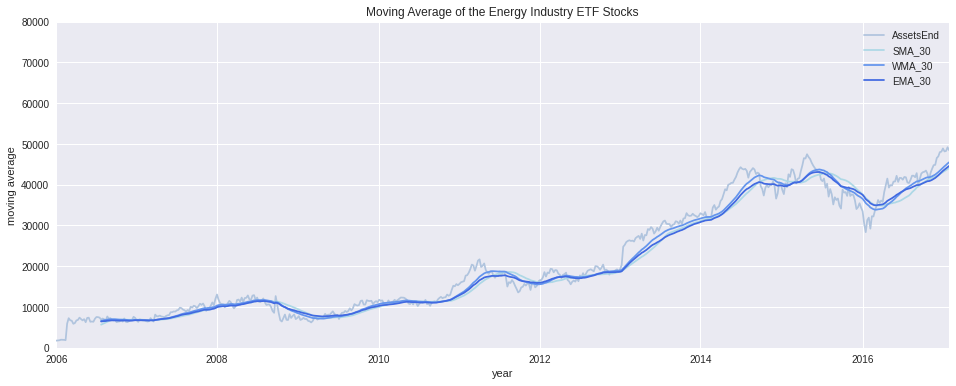

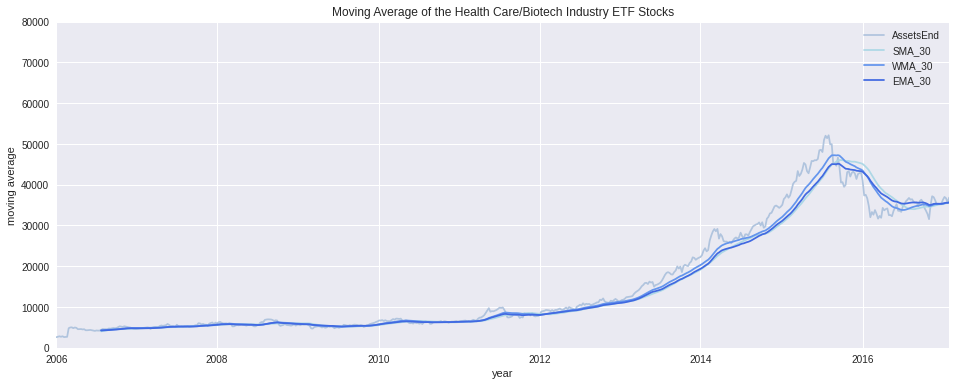

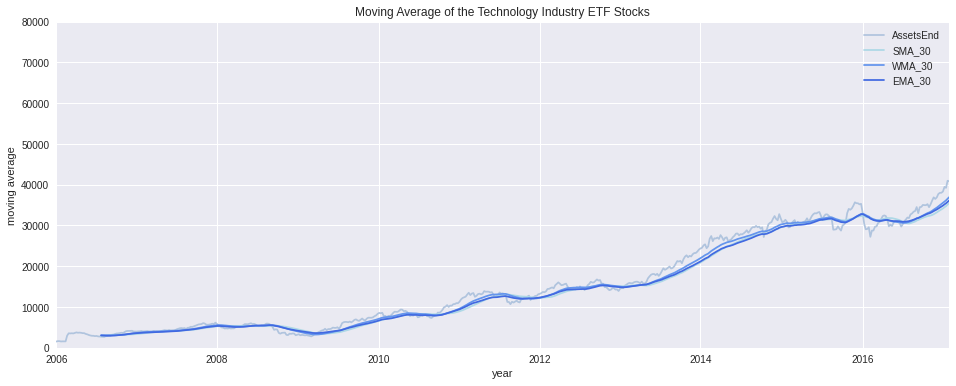

In [50]:
list_indus = ['Financials','Energy','Health Care/Biotech','Technology']
for i in list_indus:
  def SMA(AssetsEnd, n):
      return AssetsEnd.rolling(window=n).mean()

  def WMA(AssetsEnd, n):
      return AssetsEnd.rolling(window=n).apply(lambda x: x[::-1].cumsum().sum() * 2 / n / (n + 1))

  def EMA(AssetsEnd, n):
      return AssetsEnd.ewm(span=n, min_periods=n).mean()

  dataMA1 = data[(data['Industry']==i) & (data['Type']=='ETF')]
  dataMA1.sort_index(axis=0,ascending=False,inplace=True)

  dataMA1['SMA_30'] = SMA(dataMA1['AssetsEnd'], 30)
  dataMA1['WMA_30'] = WMA(dataMA1['AssetsEnd'], 30)
  dataMA1['EMA_30'] = EMA(dataMA1['AssetsEnd'], 30)
  dataMA1 = dataMA1[['ReportDate','AssetsEnd','SMA_30','WMA_30','EMA_30']]
  dataMA1.plot(kind='line', x='ReportDate', y=['AssetsEnd','SMA_30','WMA_30','EMA_30'], figsize=(16, 6), color=['lightsteelblue','lightblue','cornflowerblue','royalblue'])
  plt.legend()
  plt.xlabel('year')
  plt.ylabel('moving average')
  plt.title('Moving Average of the ' + i + ' Industry ETF Stocks')
  y_major_locator=MultipleLocator(10000)
  ax=plt.gca()
  ax.yaxis.set_major_locator(y_major_locator)
  plt.ylim(0,80000)
  plt.show()

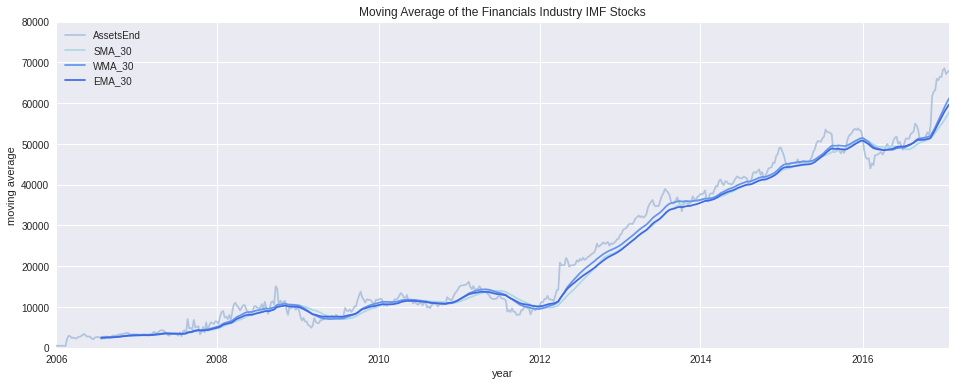

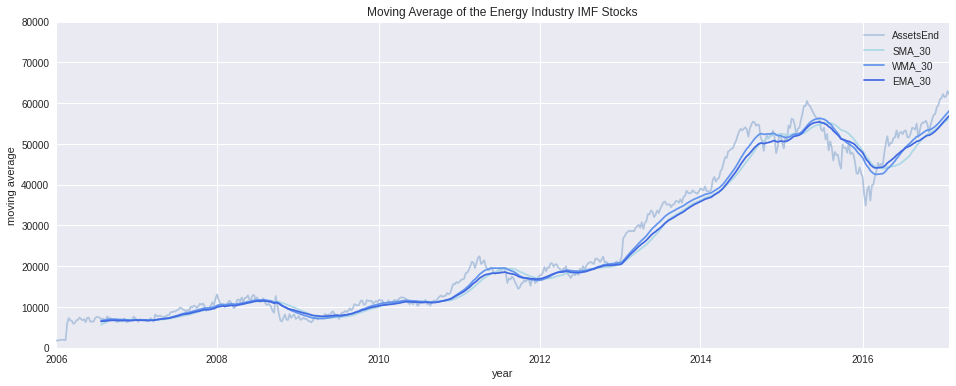

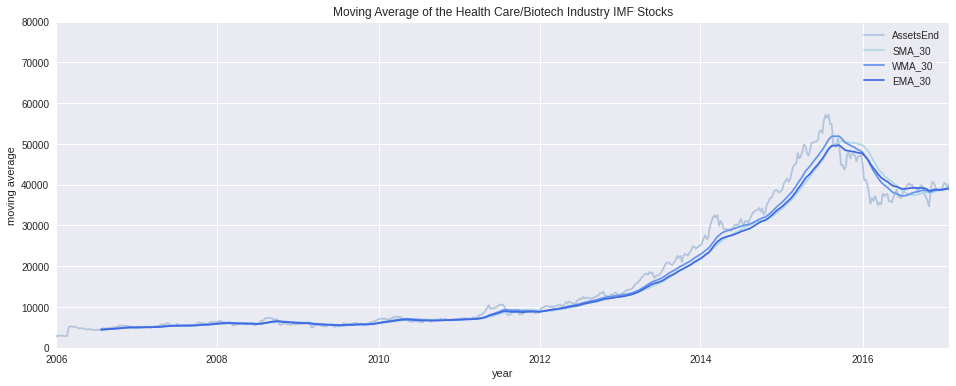

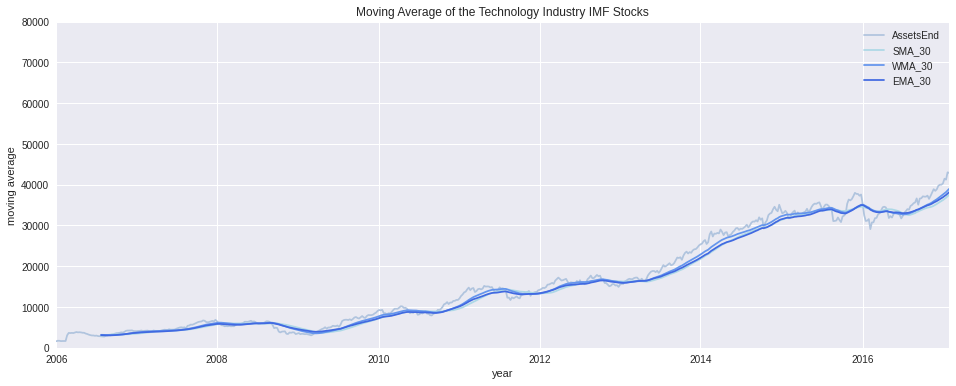

In [51]:
for i in list_indus:
  def SMA(AssetsEnd, n):
      return AssetsEnd.rolling(window=n).mean()

  def WMA(AssetsEnd, n):
      return AssetsEnd.rolling(window=n).apply(lambda x: x[::-1].cumsum().sum() * 2 / n / (n + 1))

  def EMA(AssetsEnd, n):
      return AssetsEnd.ewm(span=n, min_periods=n).mean()

  dataMA2 = data[(data['Industry']==i) & (data['Type']=='IMF')]
  dataMA2.sort_index(axis=0,ascending=False,inplace=True)

  dataMA2['SMA_30'] = SMA(dataMA2['AssetsEnd'], 30)
  dataMA2['WMA_30'] = WMA(dataMA2['AssetsEnd'], 30)
  dataMA2['EMA_30'] = EMA(dataMA2['AssetsEnd'], 30)
  dataMA2 = dataMA2[['ReportDate','AssetsEnd','SMA_30','WMA_30','EMA_30']]

  dataMA2.plot(kind='line', x='ReportDate', y=['AssetsEnd','SMA_30','WMA_30','EMA_30'], figsize=(16, 6), color=['lightsteelblue','lightblue','cornflowerblue','royalblue'])
  plt.legend()
  plt.xlabel('year')
  plt.ylabel('moving average')
  plt.title('Moving Average of the ' + i + ' Industry IMF Stocks')
  y_major_locator=MultipleLocator(10000)
  ax=plt.gca()
  ax.yaxis.set_major_locator(y_major_locator)
  plt.ylim(0,80000)
  plt.show()

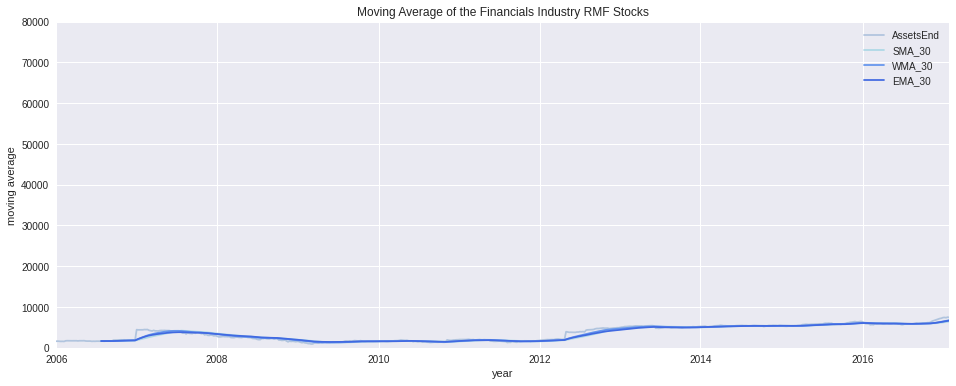

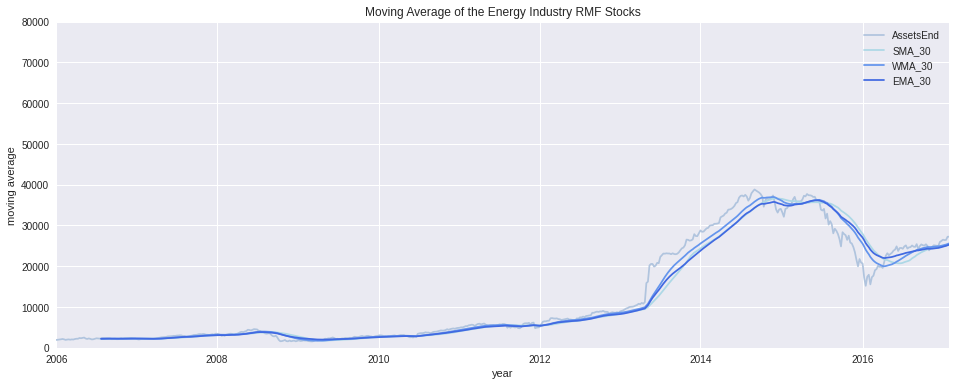

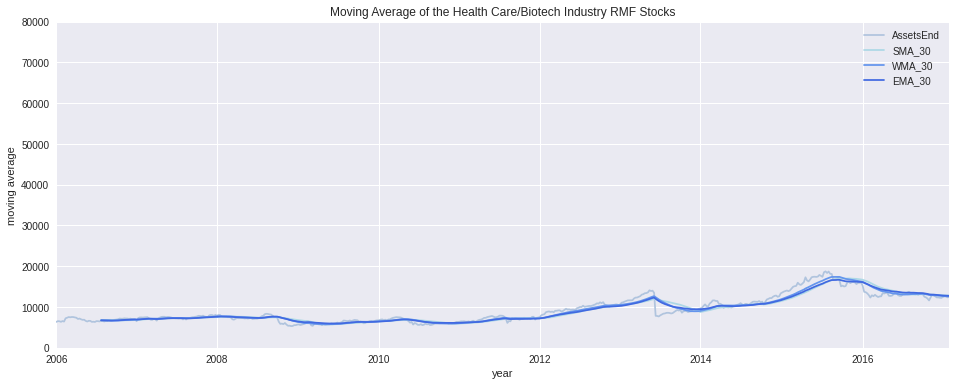

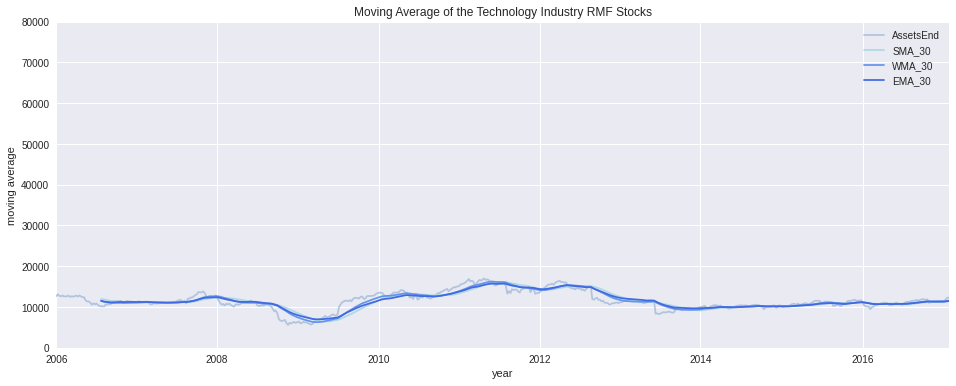

In [52]:
for i in list_indus:
  def SMA(AssetsEnd, n):
      return AssetsEnd.rolling(window=n).mean()

  def WMA(AssetsEnd, n):
      return AssetsEnd.rolling(window=n).apply(lambda x: x[::-1].cumsum().sum() * 2 / n / (n + 1))

  def EMA(AssetsEnd, n):
      return AssetsEnd.ewm(span=n, min_periods=n).mean()

  dataMA3 = data[(data['Industry']==i) & (data['Type']=='RMF')]
  dataMA3.sort_index(axis=0,ascending=False,inplace=True)

  dataMA3['SMA_30'] = SMA(dataMA3['AssetsEnd'], 30)
  dataMA3['WMA_30'] = WMA(dataMA3['AssetsEnd'], 30)
  dataMA3['EMA_30'] = EMA(dataMA3['AssetsEnd'], 30)
  dataMA3 = dataMA3[['ReportDate','AssetsEnd','SMA_30','WMA_30','EMA_30']]

  dataMA3.plot(kind='line', x='ReportDate', y=['AssetsEnd','SMA_30','WMA_30','EMA_30'], figsize=(16, 6), color=['lightsteelblue','lightblue','cornflowerblue','royalblue'])
  plt.legend()
  plt.xlabel('year')
  plt.ylabel('moving average')
  plt.title('Moving Average of the ' + i + ' Industry RMF Stocks')
  y_major_locator=MultipleLocator(10000)
  ax=plt.gca()
  ax.yaxis.set_major_locator(y_major_locator)
  plt.ylim(0,80000)
  plt.show()

###Logarithmic Rate of Return

Regarding continuous compound returns, we can get the annual cumulative return by log-cumulative method.

In [53]:
data['AssetsStart'] = data['AssetsEnd'] - data['Flow']
data.sample(3)

,ReportDate,Flow,FlowPct,AssetsEnd,PortfolioChangePct,Type,Industry,year,month,AssetsStart
10205,2006-07-19,-5.753960,-0.3564,1623.490165,0.9273,RMF,Financials,2006,7,1629.244126
6925,2010-02-10,511.807104,1.4626,34760.497448,-2.1145,ETF,Large Cap Growth,2010,2,34248.690344
9162,2007-11-14,-592.223457,-0.6101,93759.589241,-2.7951,IMF,Large Cap Growth,2007,11,94351.812697


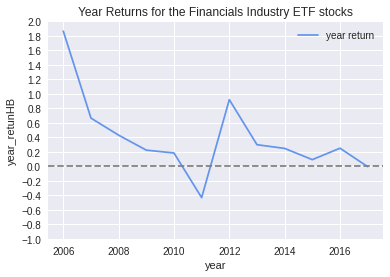

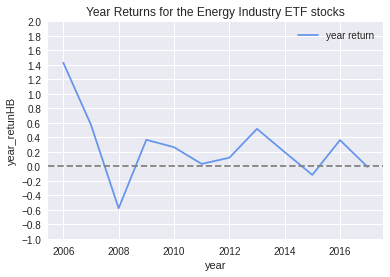

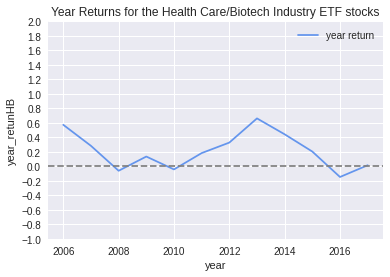

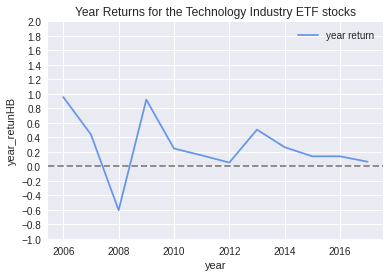

In [54]:
list_year = [2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017]
for i in list_indus:
  def funRMF(year):
    data_yHB = data[(data['year']==year ) & (data['Industry']==i) & (data['Type']=='ETF')]
    data_yHB.sort_index(axis=0,ascending=False,inplace=True)
#take log return
    dataHB = data_yHB.loc[:,['ReportDate','AssetsStart','AssetsEnd']]
    dataHB['log_price'] = np.log(dataHB['AssetsEnd'])
    dataHB['log_return'] = dataHB.log_price.diff()
    year_returnHB = dataHB.log_return.sum()
    return(year_returnHB)

  year_returnHB = [funRMF(i) for i in list_year]
  plt.plot(list_year, year_returnHB, color = 'cornflowerblue', label = 'year return')
  plt.legend()
  plt.xlabel('year')
  plt.ylabel('year_retunHB')
  plt.title('Year Returns for the ' + i + ' Industry ETF stocks')
  plt.axhline(y=0, color='grey', linestyle='--')
  plt.ylim(-1,2)
  y_major_locator=MultipleLocator(0.2)
  ax=plt.gca()
  ax.yaxis.set_major_locator(y_major_locator)
  plt.show()

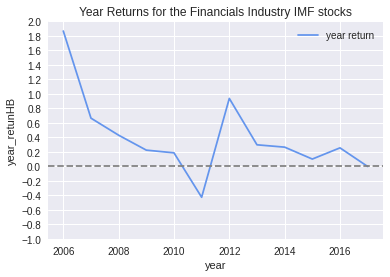

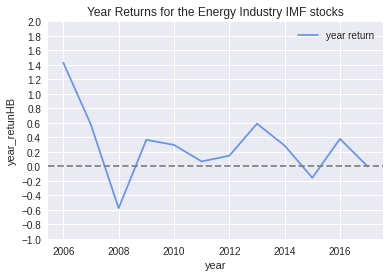

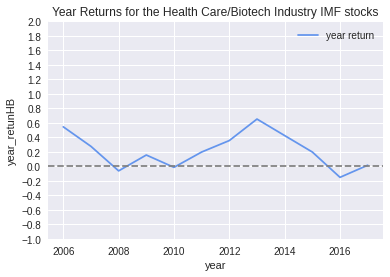

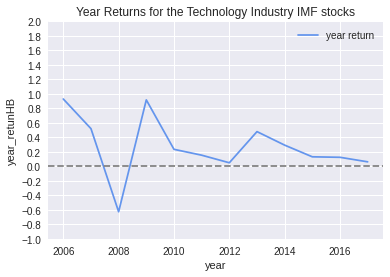

In [55]:
list_year = [2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017]
for i in list_indus:
  def funRMF(year):
    data_yHB = data[(data['year']==year ) & (data['Industry']==i) & (data['Type']=='IMF')]
    data_yHB.sort_index(axis=0,ascending=False,inplace=True)
#take log return
    dataHB = data_yHB.loc[:,['ReportDate','AssetsStart','AssetsEnd']]
    dataHB['log_price'] = np.log(dataHB['AssetsEnd'])
    dataHB['log_return'] = dataHB.log_price.diff()
    year_returnHB = dataHB.log_return.sum()
    return(year_returnHB)

  year_returnHB = [funRMF(i) for i in list_year]
  plt.plot(list_year, year_returnHB, color = 'cornflowerblue', label = 'year return')
  plt.legend()
  plt.xlabel('year')
  plt.ylabel('year_retunHB')
  plt.title('Year Returns for the ' + i + ' Industry IMF stocks')
  plt.axhline(y=0, color='grey', linestyle='--')
  plt.ylim(-1,2)
  y_major_locator=MultipleLocator(0.2)
  ax=plt.gca()
  ax.yaxis.set_major_locator(y_major_locator)
  plt.show()

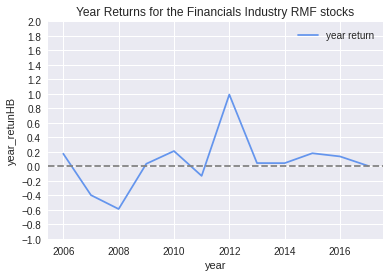

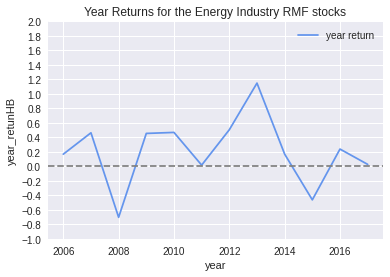

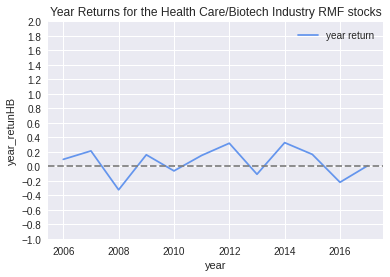

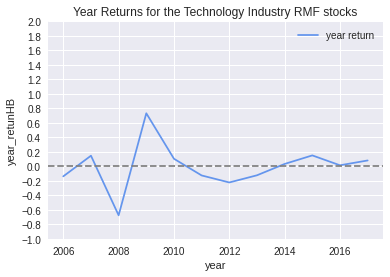

In [56]:
list_year = [2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017]
for i in list_indus:
  def funRMF(year):
    data_yHB = data[(data['year']==year ) & (data['Industry']==i) & (data['Type']=='RMF')]
    data_yHB.sort_index(axis=0,ascending=False,inplace=True)
#take log return
    dataHB = data_yHB.loc[:,['ReportDate','AssetsStart','AssetsEnd']]
    dataHB['log_price'] = np.log(dataHB['AssetsEnd'])
    dataHB['log_return'] = dataHB.log_price.diff()
    year_returnHB = dataHB.log_return.sum()
    return(year_returnHB)

  year_returnHB = [funRMF(i) for i in list_year]
  plt.plot(list_year, year_returnHB, color = 'cornflowerblue', label = 'year return')
  plt.legend()
  plt.xlabel('year')
  plt.ylabel('year_retunHB')
  plt.title('Year Returns for the ' + i + ' Industry RMF stocks')
  plt.axhline(y=0, color='grey', linestyle='--')
  plt.ylim(-1,2)
  y_major_locator=MultipleLocator(0.2)
  ax=plt.gca()
  ax.yaxis.set_major_locator(y_major_locator)
  plt.show()